# Biodiversity Intactness Index change in Phoenix subdivision
Author: Haejin Kim

Repository: https://github.com/khj9759/biodiversity_index_phoenix

## About

In 2021, Maricopa County, a significant region within the Phoenix metropolitan area, experienced its most substantial surge in developed land expansion in the United States since 2001. This rapid urban growth has raised concerns regarding its impact on biodiversity. To assess this impact, our study involves an in-depth analysis of a biodiversity dataset known as the Biodiversity Impact Index (BII), focusing on tracking changes in BII near Phoenix between 2017 and 2020

## Highlight

- Counting pixels employing NumPy functions
- Handling geospatial raster datasets for reading and writing with rioxarray
- Manipulating geospatial data using geopandas
- Generating maps utilizing contextily
- Creating and customizing SpatioTemporal Asset Catalog (STAC) maps

## About the Data

In this notebook, we utilize two datasets:

##### 1) Biodiversity Index in Phoenix City, Arizona

A global spatial model estimates human impacts on terrestrial Biodiversity Intactness, generating worldwide 100-meter gridded maps spanning from 2017 to 2020. This research extends previous studies mapping Biodiversity Intactness by leveraging the PREDICTS database, compiling biodiversity observations from over 750 studies across 32,000 sites.

Biodiversity intactness involves two key measures:
- Abundance: Indicates the number of individuals.
- Compositional Similarity: Reflects how closely the species composition resembles an undisturbed standard.

Using linear mixed effects models, spatial datasets of human impacts on these metrics are analyzed to predict outcomes. The results are projected globally across the planet's spatial layout. Detailed information is available in [2, 3].

##### 2) Arizona State Map

The second dataset comprises census data from the US Census Bureau, specifically focusing on Arizona states within the Phoenix area. Further information and metadata for this dataset are available in the 'tl_2022_04_cousub.shp' file located in the 'tl_2022_04_cousub' folder. 
File location in Website: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

## Final Output

This document aims to produce three main outputs:
1) Create a map of the Phoenix subdivision within a suitable geographical context.

<img src="image/phoenix_map.png" alt="Example Image" width="400">

2) Determine the percentage of the Phoenix subdivision area with a BII of at least 0.75 in 2017 and 2022.

- percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is 4.181 percent.
- percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020 is 3.809 percent.

3) Generate a visualization showcasing the area with BII >= 0.75 in 2017 that was lost by 2022.

<img src="image/Biodiversity_BII.png" alt="Example Image" width="400">

## Import libraries

In [36]:
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.patches as mpatches

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# other libraries for nice outputs
import contextily as ctx

## Import Data
Retrieve the shapefile for Phoenix, Arizona to access the data.

In [37]:
arizona = gpd.read_file(os.path.join('data','tl_2022_04_cousub','tl_2022_04_cousub.shp'))
# make column names small caps
arizona.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,None,None,None,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,Nogales,Nogales CCD,22,Z5,G4040,None,None,None,S,1762322938,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,None,None,None,S,1439530300,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


Access Mircosoft planetary data. 

In [38]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)

In [39]:
# access bio diversity
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
# catalog search
search = catalog.search(
    collections = ['io-biodiversity'], # list with collection id
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574],
    datetime='2017/2020'
) 

## Clean and Prepare Data 
Initially, modify the column name "Arizona" to lowercase and replace the space within it. Then, filter the data to exclusively encompass information related to Phoenix.

In [40]:
# re-assign the column names: .str.lower() makes them lower case
arizona.columns = arizona.columns.str.lower()

# filter the 'name' dataset to obtain Phoenix county
phoenix = arizona[arizona.name == "Phoenix"]

phoenix.head()

,statefp,countyfp,cousubfp,cousubns,geoid,name,namelsad,lsad,classfp,mtfcc,cnectafp,nectafp,nctadvfp,funcstat,aland,awater,intptlat,intptlon,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


## Initial Investigation
Explore the `search` to locate the item and compile a list of item names available in the STAC map.

In [41]:
# retrieve items
items = search.item_collection()

print(f'There are {len(items)} items in the search.')
    
# list of the items
items_list = {item.id: item for item in search.items()}
list(items_list)

There are 4 items in the search.


['bii_2020_34.74464974521749_-115.38597824385106_cog',
 'bii_2019_34.74464974521749_-115.38597824385106_cog',
 'bii_2018_34.74464974521749_-115.38597824385106_cog',
 'bii_2017_34.74464974521749_-115.38597824385106_cog']

Selects the datasets for the years 2017 and 2020 (`bii_2017` and `bii_2020`) and displays the list of keys associated with biodiversity data for the respective years.

In [42]:
# select the 2017 and 2022 dataset
bii_2017 = items[3]
bii_2020 = items[0]

# find the key in 2017
print("This is a 2017 bio diversity key list: ")
for key in bii_2017.assets.keys():
    print(key, '--', bii_2017.assets[key].title)
    
# find the key in 2020 
print("\nThis is a 2020 bio diversity key list: ")
for key in bii_2020.assets.keys():
    print(key, '--', bii_2020.assets[key].title)

This is a 2017 bio diversity key list: 
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview

This is a 2020 bio diversity key list: 
data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


Loads detailed raster data for biodiversity in 2017 and 2020 using the `open_rasterio` function from the rioxr library.

In [43]:
# load bii_2017 and bii_2020 data
bii_2017_detail = rioxr.open_rasterio(bii_2017.assets['data'].href)
bii_2020_detail = rioxr.open_rasterio(bii_2020.assets['data'].href)

## Matching Coordinate Reference Systems (CRS)
In order to generate the map, compare the CRS (Coordinate Reference Systems) of phoenix and bii_2017_detail, and ensure they have the same CRS by matching them.

In [44]:
# find the each crs 
phoenix.crs == bii_2017_detail.rio.crs # false
phoenix.crs #4269
bii_2017_detail.rio.crs #4326

# match it properly 
phoenix = phoenix.to_crs(bii_2017_detail.rio.crs)
phoenix.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Geographic context

Displaying the Phoenix subdivision borders on a map from Esri's National Geographic World Map. It labels the map and shows the Phoenix area in its geographical context

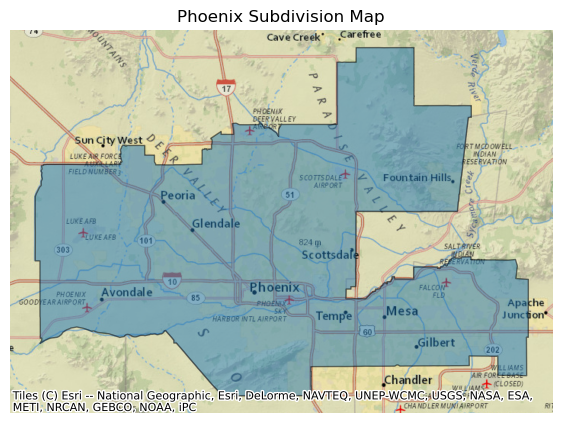

In [45]:
# add Pheonix area boundary
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k"))

# --------------------------------------
# add basemap from contextily
ctx.add_basemap(ax, source = ctx.providers.Esri.NatGeoWorldMap)

# Customization
ax.set_title('Phoenix Subdivision Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# add layers
# update axes
ax.set_axis_off()

# display figure
plt.show()
# save the png file
#plt.savefig('phoenix_map.png', bbox_inches='tight',  dpi=100)

## Clip the biodiversity data on Phoenix area 
clips or isolates specific data from larger datasets (bii_2017_detail and bii_2020_detail) to include only the geographical area corresponding to Phoenix. This is achieved using the rio.clip function and the boundary geometry of the Phoenix area (phoenix.geometry). The resulting data, namely clip_bii_2017 and clip_bii_2020, represents the biodiversity information limited to the geographic extent of Phoenix.

In [46]:
# clip the data only including phoenix area
clip_bii_2017 = bii_2017_detail.rio.clip(phoenix.geometry)
clip_bii_2020 = bii_2020_detail.rio.clip(phoenix.geometry)

## Conversion of Boolean Values to Binary (0 or 1) Based on BII Threshold

To identify pixels that changed values from 2017 to 2020, we'll focus on areas where the BII (Biodiversity Impact Index) is greater than or equal to 0.75 in both 2017 and 2020. Whenever the value is represented as True or False, it needs to be converted into 0 or 1, respectively.

In [ ]:
# Find the values over 0.75 in 2017 and 2020
bii_2017_least = clip_bii_2017 >= 0.75
bii_2020_least = clip_bii_2020 >= 0.75

# Assign data with True as 1 and False as 0
above_2017 = bii_2017_least.astype(int)
above_2020 = bii_2020_least.astype(int)

## Pixel Counting

This section covers the process of pixel enumeration utilizing a NumPy array to ascertain the count of pixels within a particular classification or category.

In [ ]:
## calculate the pixel size 
above_2017_pixel =np.unique(above_2017, return_counts = True)
above_2020_pixel =np.unique(above_2020, return_counts = True)

Segment extracts and presents pixel size and count data for 2017 and 2020, aiding the analysis of changes in Biodiversity Intactness over the specified years.

In [ ]:
# Unpack the difference_pixel data
# Extract pixel sizes and counts for 2017
above_2017_pixel_count = {
    'pixel_size': above_2017_pixel[0],
    'n_pixel': above_2017_pixel[1],
}
print('Pixel sizes and counts in 2017:',above_2017_pixel_count)

# Extract pixel sizes and counts for 2020
above_2020_pixel_count = {
    'pixel_size': above_2020_pixel[0],
    'n_pixel': above_2020_pixel[1],
}
print('Pixel sizes and counts in 2020:',above_2020_pixel_count)

Pixel sizes and counts in 2017: {'pixel_size': array([0, 1]), 'n_pixel': array([553037,  24133])}
Pixel sizes and counts in 2020: {'pixel_size': array([0, 1]), 'n_pixel': array([555184,  21986])}


## Pixel Count for Percentage of Area

Creates DataFrames for pixel counts in 2017 and 2020. 
Calculates the total pixels for both years and then computes the percentage of pixels falling into specific classes (using index 1). Finally, it displays the calculated percentage of the Phoenix subdivision area with a Biodiversity Intactness Index (BII) of at least 0.75 for both 2017 and 2020.


In [ ]:
# Create a DataFrame from the pixel counts
pix_counts_2017 = pd.DataFrame(above_2017_pixel_count)
pix_counts_2020 = pd.DataFrame(above_2020_pixel_count)

# Calculate total pixels
total_pixels_2017 = pix_counts_2017['n_pixel'].sum()
total_pixels_2020 = pix_counts_2020['n_pixel'].sum()

# Calculate the percentage of pixels for specific classes (e.g., index 0 and 2)
pixels_2017 = pix_counts_2017['n_pixel'][1] 
percent_2017 = (pixels_2017/ total_pixels_2017) * 100

pixels_2020 = pix_counts_2020['n_pixel'][1] 
percent_2020 = (pixels_2020/ total_pixels_2020) * 100

# Display the calculated percentage of pixels
print('percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is',round(percent_2017,3), 'percent.')
print('percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020 is',round(percent_2020,3), 'percent.')


percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is 4.181 percent.
percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020 is 3.809 percent.


## Filter Values as 1
Identifying and isolating data points in the dataset that exclusively contain the value 1, possibly representing specific conditions such as Biodiversity Intactness Index (BII) values equal to or above 0.75 in 2017 and 2020.

In [ ]:
# Measure the BII >= 0.75 in 2017 and 2020
difference = above_2017 - above_2020

# Identify values equal to 1
not_1 = difference.where(difference ==1)

## Clip the geometry 
Clip the geometry to display areas exclusively with value 1, otherwise set as transparent

In [ ]:
# Assuming 'not_1' is another raster dataset loaded using Rasterio
# NaN becomes transparent in future plot
not_1 = not_1.rio.clip(phoenix.geometry)

## Map

Generate a Matplotlib map illustrating the loss of Biodiversity Index values over 0.75 between 2017 and 2020 in Phoenix, AZ.

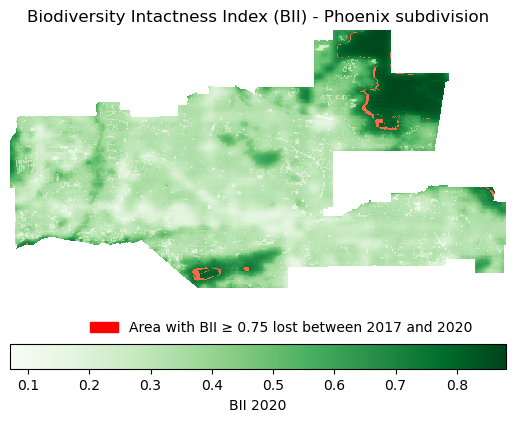

<Figure size 640x480 with 0 Axes>

In [ ]:
# Creating a Matplotlib figure and axis
fig, ax = plt.subplots()
ax.axis('off')

# -------------------------------
# Plotting the clipped raster
clip_bii_2017.plot(ax=ax, cmap='Greens', cbar_kwargs={'orientation': 'horizontal', 'label': 'BII 2020'})


# Plotting the 'not_1' raster on the same axis without a colorbar
not_1.plot(ax=ax, cmap='#FF0000', add_colorbar=False)


# -------------------------------
# Creating a legend patch
red_patch = mpatches.Patch(color='red', label='Area with BII ≥ 0.75 lost between 2017 and 2020')

# Adding the legend to the plot
ax.legend(handles=[red_patch], frameon=False, loc=(0.15, -0.2))

# -------------------------------
# Customizing the plot title and axes labels
ax.set_title('Biodiversity Intactness Index (BII) - Phoenix subdivision')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Removing the axes
ax.set_axis_off()

# -------------------------------
# Displaying the figure
plt.show()

# save the png file
plt.savefig('Biodiversity_BII.png', bbox_inches='tight',  dpi=100)